In [1]:
import glob
import functools
import urllib2

import pandas as pd
import json
import gspread
import pandas as pd
import os
from IPython.core.display import HTML
from oauth2client.client import SignedJwtAssertionCredentials
import numpy as np
import shutil

#Important Data Metadata
Barcodes to split on and their ids 
illumina adapters and their IDs so I can make name dcisions

In [2]:
barcodes = """AAGCAAT A01
GGCTTGT B06
ACAAGTT C01
TGGTCCT D08fixed
ATGACCNNNNT  A03
TCCTGTNNNNT  G07
CAGCTTNNNNT  A04
GGATACNNNNT  F05
NNNNNCCTATAT X1A
NNNNNTGCTATT X1B
NNNNNTATACTT X2A
NNNNNATCTTCT X2B""".split("\n")


barcodes = dict([item.split() for item in barcodes])
barcode_name_to_sequence = {value.strip(): key.strip() for key, value in barcodes.items()}

#overlap is for the second trimimg round to throw out doube ligation events on the end of read 2 (we ignore tripple ligation events)
#only issue is actually A03-F05 where we might be trimming Ts off the start of read 1 and causing dove tailing events
overlap = """A01 5
B06 5
C01 5
D08fixed 5
A03 9
G07 9 
A04 9
F05 9
none 5
X1A 10
X1B 10
X2A 10
X2B 10""".split("\n")


overlap = dict([item.split() for item in overlap])

illumina_adapters = """501 TATAGCCT 
502 ATAGAGGC 
503 CCTATCCT 
504 GGCTCTGA 
505 AGGCGAAG 
506 TAATCTTA 
507 CAGGACGT 
508 GTACTGAC 
502s ATA 
503s CCT
504s GGC
505s AGG
506s TAA
507s CAG
508s GTA
701 ATTACTCG
702 TCCGGAGA
703 CGCTCATT
704 GAGATTCC
705 ATTCAGAA
706 GAATTCGT""".split("\n")

illumina_adapters = pd.DataFrame([item.strip().split() for item in illumina_adapters], columns=["label", "barcode"])
illumina_adapters = illumina_adapters.set_index("label")

adapters = """A01    ATTGCTTAGATCGGAAGAGCGTCGTGT
B06    ACAAGCCAGATCGGAAGAGCGTCGTGT
C01    AACTTGTAGATCGGAAGAGCGTCGTGT
D08fixed    AGGACCAAGATCGGAAGAGCGTCGTGT
A03    ANNNNGGTCATAGATCGGAAGAGCGTCGTGT
G07    ANNNNACAGGAAGATCGGAAGAGCGTCGTGT
A04    ANNNNAAGCTGAGATCGGAAGAGCGTCGTGT
F05    ANNNNGTATCCAGATCGGAAGAGCGTCGTGT
none   AGATCGGAAGAGCGTCGTGT
X1A    ATATAGGNNNNNAGATCGGAAGAGCGTCGTGTAG
X1B    AATAGCANNNNNAGATCGGAAGAGCGTCGTGTAG 
X2A    AAGTATANNNNNAGATCGGAAGAGCGTCGTGTAG
X2B    AGAAGATNNNNNAGATCGGAAGAGCGTCGTGTAG""".split("\n")
adapters = dict([item.split() for item in adapters])



five_prime_adapter = "CTTCCGATCT"

#Get Manifest from Google Docs

In [3]:
json_key = json.load(open("/home/gpratt/ipython_notebook/public clip-588adbc137f3.json"))
scope = ['https://spreadsheets.google.com/feeds']

credentials = SignedJwtAssertionCredentials(json_key['client_email'], json_key['private_key'], scope)
gc = gspread.authorize(credentials)

sht1 = gc.open_by_url("https://docs.google.com/spreadsheets/d/1ZU2mQh54jentqvhR_oMnviLGWR8Nw_x338gULzKjNDI/edit#gid=0")
ws = sht1.worksheet("Sheet1")
list_of_lists = ws.get_all_values()
manifest = pd.DataFrame(list_of_lists[1:], columns=list_of_lists[0])
manifest.is_encode = manifest.is_encode == "TRUE"
manifest.is_4000 = manifest.is_4000 == "TRUE"

manifest.method_Paper_flag = manifest.Method_Paper_flag == "TRUE" 
manifest['exp_id'] = manifest.ENCODE_ID.apply(lambda x: x.split("_")[0])

In [4]:
def format_file(index, adapter):
    index_1 = illumina_adapters.ix[index.index_1].values[0]
    index_2 = illumina_adapters.ix[index.index_2].values[0]
    if index.Lane == "": #Incase we are doing a rapid run and there isn't lane info
        sample_name = "{}_{}-{}_{}.fastq.gz".format(index.Hiseq_file_name, index_2, index_1, adapter)
        dir_name = "Sample_{}".format(index.Hiseq_file_name)

    #For Sebastians samples Sample_G3BP-S-input/G3BP-S-input_S1_L001_R1.fastq.gz
    elif index.Lane.startswith("S") and "L" in index.Lane:
        name = index.Hiseq_file_name
        sample_name = "{}_{}_{}.fastq.gz".format(name, index.Lane, adapter)
        dir_name = index.Hiseq_file_name
    
    elif index.Lane.startswith("S"):
        name = index.Hiseq_file_name.split("-")[0].replace("_", "-")
        sample_name = "{}_{}_{}.fastq.gz".format(name, index.Lane, adapter)
        dir_name = index.Hiseq_file_name
 
    #This needs to go above my other 4000 check because of name colisions
    elif index.is_4000:
        sample_name = "{}_{}_{}_001.fastq.gz".format(index.Hiseq_file_name, index.Lane, adapter)
        return os.path.join(index.file_location, sample_name)
    
    #this is a bit hacky, keep an eye on it
    elif "4000" in index.Hiseq_file_name:
        sample_name = index.Hiseq_file_name + ".fastq.gz"
        sample_name = sample_name.replace("R1", adapter)
        return os.path.join(index.file_location, sample_name)
      
    else:
        sample_name = "{}_{}-{}_{}_{}.fastq.gz".format(index.Hiseq_file_name, index_2, index_1, index.Lane, adapter)
        dir_name = "Sample_{}".format(index.Hiseq_file_name)
    return os.path.join(index.file_location, dir_name, sample_name)

In [5]:
manifest['r1'] = manifest.apply(functools.partial(format_file, adapter="R1"), axis=1)
manifest['r2'] = manifest.apply(functools.partial(format_file, adapter="R2"), axis=1)

#Make sure there are no duplicated names or ids in the encode manifest

In [6]:
input_manifest_check = manifest[manifest.inline_1 == "none"]
manifest_grouped_manifest = input_manifest_check.groupby(["Hiseq_file_name"]).count()
manifest_grouped_manifest[manifest_grouped_manifest.RBP > 1]

,ENCODE_ID,RBP,inline_1,inline_2,index_1,index_2,Lane,file_location,unmerged_location,original_file_name,...,cell_type,hiseq_run_date,randomer_length,,Method_Paper_flag,species,is_4000,exp_id,r1,r2
Hiseq_file_name,,,,,,,,,,,,,,,,,,,,,


In [7]:
manifest_grouped_manifest = manifest.groupby(["Hiseq_file_name", "ENCODE_ID"]).count()
manifest_grouped_manifest[manifest_grouped_manifest.RBP > 1]

,,RBP,inline_1,inline_2,index_1,index_2,Lane,file_location,unmerged_location,original_file_name,is_encode,cell_type,hiseq_run_date,randomer_length,,Method_Paper_flag,species,is_4000,exp_id,r1,r2
Hiseq_file_name,ENCODE_ID,,,,,,,,,,,,,,,,,,,,


In [8]:
manifest_grouped_manifest = manifest.groupby(["ENCODE_ID"]).count()
manifest_grouped_manifest[manifest_grouped_manifest.RBP > 1]

,Hiseq_file_name,RBP,inline_1,inline_2,index_1,index_2,Lane,file_location,unmerged_location,original_file_name,...,cell_type,hiseq_run_date,randomer_length,,Method_Paper_flag,species,is_4000,exp_id,r1,r2
ENCODE_ID,,,,,,,,,,,,,,,,,,,,,


In [9]:
unprocessed_datasets = manifest.ix[~manifest['r1'].apply(os.path.exists)]

for x in unprocessed_datasets.r1:
    print x

/projects/ps-yeolab/seqdata/igm-storage1.ucsd.edu/160328_D00611_0252_AHKVLHBCXX/Data/Fastq/SA1_WT_SS_IN_L003_R1_001.fastq.gz
/projects/ps-yeolab/seqdata/igm-storage1.ucsd.edu/160328_D00611_0252_AHKVLHBCXX/Data/Fastq/SA2_WT_SS_PARP_L003_R1_001.fastq.gz
/projects/ps-yeolab/seqdata/igm-storage1.ucsd.edu/160328_D00611_0252_AHKVLHBCXX/Data/Fastq/SA3_WT_3P_IN_L003_R1_001.fastq.gz
/projects/ps-yeolab/seqdata/igm-storage1.ucsd.edu/160328_D00611_0252_AHKVLHBCXX/Data/Fastq/SA4_WT_3P_PARP_L003_R1_001.fastq.gz
/projects/ps-yeolab/seqdata/igm-storage1.ucsd.edu/160328_D00611_0252_AHKVLHBCXX/Data/Fastq/SA5_KO_SS_IN_L003_R1_001.fastq.gz
/projects/ps-yeolab/seqdata/igm-storage1.ucsd.edu/160328_D00611_0252_AHKVLHBCXX/Data/Fastq/SA6_KO_SS_PARP_L003_R1_001.fastq.gz
/projects/ps-yeolab/seqdata/igm-storage1.ucsd.edu/160328_D00611_0252_AHKVLHBCXX/Data/Fastq/SA7_KO_3P_IN_L003_R1_001.fastq.gz


#Togle Datasets to be processed

In [10]:
#manifest = manifest[manifest.method_Paper_flag]

#Make demuxing stuffs

In [11]:
clip_seq_manifest = manifest[manifest.inline_1 != "none"].copy()
input_manifest = manifest[manifest.inline_1 == "none"].copy()

In [12]:
tscc_dir = "/home/gpratt/projects/encode/scripts/barcodes/encode_barcodes"

In [13]:
clip_seq_manifest['inline_name_1'] = clip_seq_manifest.apply(lambda x: "{}_{}_{}".format(x.inline_1, x.ENCODE_ID, x.RBP), axis=1)
clip_seq_manifest['inline_name_2'] = clip_seq_manifest.apply(lambda x: "{}_{}_{}".format(x.inline_2, x.ENCODE_ID, x.RBP), axis=1)

In [14]:
#Writes barcodes to approprate locations
for lane, manifest_by_lane in clip_seq_manifest.groupby("Lane"):
    for file_name, df in manifest_by_lane.groupby("Hiseq_file_name"):

        cur_barcodes = barcodes.copy()
        for key, series in df.iterrows():
            try:
                inline_1 = barcode_name_to_sequence[series.inline_1]
                inline_2 = barcode_name_to_sequence[series.inline_2]
                cur_barcodes[inline_1] = series.inline_name_1
                cur_barcodes[inline_2] = series.inline_name_2
            except KeyError as e:
                print "Key Error, barcode", e, "doesn't exit, won't demux", series.ENCODE_ID
        barcode_file = os.path.join(tscc_dir, file_name + ".txt")
        with open(barcode_file, 'w') as fn:
            for key, value in cur_barcodes.items():
                fn.write("{}\t{}\n".format(key, value))
                
barcode_file = os.path.join(tscc_dir, "barcodes.txt")
with open(barcode_file, 'w') as fn:
    for key, value in barcodes.items():
        fn.write("{}\t{}\n".format(key, value))

In [15]:
#Functions to format output
def create_demuxer(barcode, r1, r2, length, outdir):
    out_file_1 = os.path.join(outdir, os.path.basename(r1))
    out_file_2 = os.path.join(outdir, os.path.basename(r2))

    metrics = os.path.basename(barcode)
    
    return "demux_paired_end.py --fastq_1 {} --fastq_2 {} -b {} --out_file_1 {} --out_file_2 {} --length {} -m {}".format(r1, r2, barcode, out_file_1, out_file_2, length, metrics)


def create_demuxer_input(barcode, r1, r2, length, outdir):
    out_file_1 = os.path.join(outdir, os.path.basename(r1))
    out_file_2 = os.path.join(outdir, os.path.basename(r2))
    
    metrics = os.path.basename(barcode)
    
    return "demux_paired_end.py --fastq_1 {} --fastq_2 {} -b {} --out_file_1 {} --out_file_2 {} --length {} -m {}".format(r1, r2, barcode, out_file_1, out_file_2, length, metrics)

#Make downstream file names

In [16]:
#split_out_dir = "/projects/ps-yeolab2/encode/analysis/encode_split"
split_out_dir = "/home/gpratt/projects/encode/analysis/encode_split" #this is the old dir switching to stable ps-yeolab space

def make_processing_name(series, inline_name):
    
    r1 = os.path.basename(series.r1).split(".")
    r1.insert(-2, series[inline_name])
    r1 = ".".join(r1)
    
    r2 = os.path.basename(series.r2).split(".")
    r2.insert(-2, series[inline_name])
    r2 = ".".join(r2)

    return ";".join([os.path.join(split_out_dir, r1), 
                     os.path.join(split_out_dir, r2)])

def make_input_processing_name(series):
    
    r1 = os.path.basename(series.r1).split(".")
    r1.insert(-2, "unassigned")
    r1 = ".".join(r1)
    
    r2 = os.path.basename(series.r2).split(".")
    r2.insert(-2, "unassigned")
    r2 = ".".join(r2)

    return ";".join([os.path.join(split_out_dir, r1), 
                     os.path.join(split_out_dir, r2)])

In [17]:
clip_seq_manifest['processing_name_1'] = clip_seq_manifest.apply(functools.partial(make_processing_name, inline_name="inline_name_1"), axis=1)
clip_seq_manifest['processing_name_2'] = clip_seq_manifest.apply(functools.partial(make_processing_name, inline_name="inline_name_2"), axis=1)

input_manifest['processing_name'] = input_manifest.apply(make_input_processing_name, axis=1)

In [18]:
clip_seq_manifest.to_csv("clipseq_manifest.csv")
input_manifest.to_csv("input_manifest.csv")

#Write Demuxing Code

In [19]:
#output results in list, only outputs unprocessed datasets
total = 0 
result = []
for lane, manifest_by_lane in clip_seq_manifest.groupby("Lane"):
    for file_name, series in manifest_by_lane.groupby("Hiseq_file_name").first().iterrows():

        #Skip if the file has already been demuxed
        if os.path.exists(series.processing_name_1.split(";")[0]):
            continue

        total = total % 500
        total += 1
        barcode_location = os.path.join(tscc_dir, series.name + ".txt")
        result.append('cmd[{}]=\"{}\"'.format(total, create_demuxer(barcode_location, series.r1, series.r2, series.randomer_length, split_out_dir)))

for lane, manifest_by_lane in input_manifest.groupby("Lane"):
#for lane, manifest_by_lane in input_manifest[~input_manifest['r1'].apply(os.path.exists)].groupby("Lane"):
    for file_name, series in manifest_by_lane.groupby("Hiseq_file_name").first().iterrows():

        #Skip if the file has already been demuxed
        if os.path.exists(series.processing_name.split(";")[0]):
            continue

        total = total % 500
        total += 1
        barcode_location = "/home/gpratt/projects/encode/scripts/barcodes/encode_barcodes/barcodes.txt"
        result.append('cmd[{}]=\"{}\"'.format(total, create_demuxer_input(barcode_location, series.r1, series.r2, series.randomer_length, split_out_dir)))
        #result.append('cmd[{}]=\"{}\"'.format(total, create_demuxer_input(barcode_location, series.r2, split_out_dir)))

In [20]:
def eplouge(count):
    return """#!/bin/bash
#PBS -N barcode_spliter
#PBS -l nodes=1:ppn=1
#PBS -o 20150224_splitter.out
#PBS -e 20150224_splitter.err
#PBS -V
#PBS -q home-yeo
#PBS -W group_list=yeo-group
#PBS -t 1-{}
#PBS -l walltime=12:00:00
cd /home/gpratt/projects/encode/data/encode_split
echo "hello, starting"
""".format(count)

prolouge = "eval ${cmd[$PBS_ARRAYID]}"

In [21]:
with open(os.path.join("/home/gpratt/projects/encode/scripts", "encode_demux_1.sh"), 'w') as out_file:
    out_file.write(eplouge(500))
    for line in result[:500]:
        out_file.write(line + "\n\n")
    out_file.write(prolouge + "\n")
    
with open(os.path.join("/home/gpratt/projects/encode/scripts", "encode_demux_2.sh"), 'w') as out_file:
    out_file.write(eplouge(len(result[500:])))
    for line in result[500:]:
        out_file.write(line + "\n\n")
    out_file.write(prolouge + "\n")

#Make the files to process

In [22]:
def make_current_adapters(adapter1, adapter2, triming_len  = 15):
    result = []
    for x in range(len(adapter1) - triming_len + 1):
        short_adapter1 = adapter1[x:x+triming_len]
        short_adapter2 = adapter2[x:x+triming_len]
        if short_adapter1 == short_adapter2:
            result.append(short_adapter1)
        else:
            result += list([short_adapter1, short_adapter2])
    return ";".join(result)

def make_five_prime_adapters(adapter1, adapter2):
    result = []
    result.append(five_prime_adapter + adapter1)
    result.append(five_prime_adapter + adapter2)
    result = list(set(result))
    #This adapter is incase read 1 and read 2 overlap badly
    return ";".join(result)

#Check if individual files exist
only make the manifest it they do

In [24]:
#out_dir_hg19 = "/projects/ps-yeolab/encode/analysis/encode_v13/"
out_dir_hg19 = "/projects/ps-yeolab2/encode/analysis/encode_v12/"

out_dir_mm9 = "/projects/ps-yeolab2/encode/analysis/encode_mouse_v8/"

def define_basename(row):
    if row.species == "hg19":
        return os.path.join(out_dir_hg19, ".".join(os.path.basename(row.processing_name.split(";")[0]).split(".")[:-2]))
    if row.species == "mm9":
        return os.path.join(out_dir_mm9, ".".join(os.path.basename(row.processing_name.split(";")[0]).split(".")[:-2]))

input_manifest['base_name'] = input_manifest.apply(define_basename, axis=1)
input_manifest['input_bam'] = input_manifest.base_name.apply(lambda x: ".".join([x, "adapterTrim.round2.rmRep.rmDup.sorted.bam"]))
input_manifest['input_peaks'] = input_manifest.base_name.apply(lambda x: ".".join([x, "adapterTrim.round2.rmRep.rmDup.sorted.r2.peaks.fixed.bb"]))

def define_basename_merged(row):
    if row.species == "hg19":
        return os.path.join(out_dir_hg19, "{}_{}".format(row['ENCODE_ID'], row['RBP']))
    if row.species == "mm9":
        return os.path.join(out_dir_mm9, "{}_{}".format(row['ENCODE_ID'], row['RBP']))

clip_seq_manifest['merged_base_name'] = clip_seq_manifest.apply(define_basename_merged, axis=1)
clip_seq_manifest['merged_bam'] = clip_seq_manifest.apply(lambda x: "{}.merged.r2.bam".format(x.merged_base_name), axis=1) 
clip_seq_manifest['merged_peaks'] = clip_seq_manifest.apply(lambda x:  "{}.merged.r2.peaks.fixed.bb".format(x.merged_base_name), axis=1) 

In [25]:
rerun = """459_CLIP_S29
459_CLIP_S29
459_INPUT_S30
235_CLIP_S53
235_CLIP_S53
235_INPUT_S54
284_CLIP_S55
284_CLIP_S55
284_INPUT_S56
285_CLIP_S57
285_CLIP_S57
390_CLIP_S59
390_CLIP_S59
390_INPUT_S60
534_CLIP_S1
534_CLIP_S1
534_INPUT_S2
567_CLIP_S51
567_CLIP_S51
567_INPUT_S52
570_CLIP_S3
570_CLIP_S3
570_INPUT_S4
580_CLIP_S11
580_CLIP_S11
580_INPUT_S12
584_CLIP_S21
584_CLIP_S21
584_INPUT_S22
590_CLIP_S7
590_CLIP_S7
590_INPUT_S8
591_CLIP_S13
591_CLIP_S13
591_INPUT_S14
592_CLIP_S5
592_CLIP_S5
592_INPUT_S6
593_CLIP_S15
593_CLIP_S15
593_INPUT_S16
594_CLIP_S23
594_CLIP_S23
594_INPUT_S24
598_CLIP_S17
598_CLIP_S17
598_INPUT_S18
614_CLIP_S25
614_CLIP_S25
614_INPUT_S26
622_CLIP_S27
622_CLIP_S27
622_INPUT_S28
624_CLIP_S29
624_CLIP_S29
624_INPUT_S30
627_CLIP_S9
627_CLIP_S9
627_INPUT_S10
631_CLIP_S19
631_CLIP_S19
631_INPUT_S20
LNG10-E_INPUT_S61
LNG10-E_CLIP_S62
LNG10-N_INPUT_S63
LNG10-N_CLIP_S64
LNG10-M_INPUT_S65
LNG10-M_CLIP_S66
LNG10-S_INPUT_S67
LNG10-S_CLIP_S68
LNG9-E_INPUT_S69
LNG9-E_CLIP_S70
LNG9-N_INPUT_S71
LNG9-N_CLIP_S72
LNG9-M_INPUT_S73
LNG9-M_CLIP_S74
LNG9-S_INPUT_S75
LNG9-S_CLIP_S76
LNG1-E_INPUT_S77
LNG1-E_CLIP_S78
LNG1-N_INPUT_S79
LNG1-N_CLIP_S80
LNG1-M_INPUT_S81
LNG1-M_CLIP_S82
LNG1-S_INPUT_S83
LNG1-S_CLIP_S84
LNG19-E_INPUT_S85
LNG19-E_CLIP_S86
LNG19-N_INPUT_S87
LNG19-N_CLIP_S88
LNG20-E_INPUT_S89
LNG20-E_CLIP_S90
LNG20-N_INPUT_S91
LNG20-N_CLIP_S92
323_01_CLIP_S8""".split("\n")

In [26]:
#This is for just running stuff thats not done yet
input_manifest_run = input_manifest[~(input_manifest['input_bam'].apply(os.path.exists) & input_manifest['input_peaks'].apply(os.path.exists)) | (input_manifest.Hiseq_file_name.isin(rerun))]
# input_manifest_run = input_manifest_run[~input_manifest_run.inline_1.isin(['X1A', 'X1B', 'X2A', 'X2B', 'C06'])]
# input_manifest_run = input_manifest_run[~input_manifest_run.inline_2.isin(['X1A', 'X1B', 'X2A', 'X2B', 'C06'])]

clip_seq_manifest_run = clip_seq_manifest[~(clip_seq_manifest.merged_bam.apply(os.path.exists) & clip_seq_manifest.merged_peaks.apply(os.path.exists)) | clip_seq_manifest.Hiseq_file_name.isin(rerun)]
# clip_seq_manifest_run = clip_seq_manifest_run[~clip_seq_manifest_run.inline_1.isin(['X1A', 'X1B', 'X2A', 'X2B', 'C06'])]
# clip_seq_manifest_run = clip_seq_manifest_run[~clip_seq_manifest_run.inline_2.isin(['X1A', 'X1B', 'X2A', 'X2B', 'C06'])]

# #This is for an allup run
# input_manifest_run = input_manifest
# clip_seq_manifest_run = clip_seq_manifest

In [27]:
#Make Manifest for human files
with open(os.path.join("/home/gpratt/projects/encode/scripts", "encode_v12.txt"), 'w') as out_file: 
    for name, line in clip_seq_manifest_run[clip_seq_manifest_run.species == "hg19"].iterrows():
        current_adapters = make_current_adapters(adapters[line.inline_1], adapters[line.inline_2])
        five_prime_adapters = make_five_prime_adapters(barcode_name_to_sequence[line.inline_1], 
                                                       barcode_name_to_sequence[line.inline_2])
        
        out_file.write("\t".join([line.processing_name_1, 
                                  "hg19", 
                                  line.ENCODE_ID + "_" + line.RBP, 
                                  current_adapters,
                                  overlap[line.inline_1],
                                  five_prime_adapters,
                                 line.randomer_length]) + '\n')
        out_file.write("\t".join([line.processing_name_2, 
                                  "hg19", 
                                  line.ENCODE_ID + "_" + line.RBP, 
                                  current_adapters,
                                  overlap[line.inline_2],
                                  five_prime_adapters,
                                 line.randomer_length]) + '\n')
        
    for name, line in input_manifest_run[input_manifest_run.species == "hg19"].iterrows(): 
        
        #I wrote the function badly, this is a hack around that...
        current_adapters = make_current_adapters(adapters["none"], adapters["none"])
        five_prime_adapters = make_five_prime_adapters("", "")
        out_file.write("\t".join([line.processing_name, 
                                  "hg19", 
                                  line.ENCODE_ID + "_" + line.RBP,
                                  current_adapters,
                                  overlap["none"],
                                  five_prime_adapters,
                                  line.randomer_length
                                  ]) + '\n')
        
#Make Manifest for mouse files
with open(os.path.join("/home/gpratt/projects/encode/scripts", "encode_mouse_v8.txt"), 'w') as out_file: 
    for name, line in clip_seq_manifest[clip_seq_manifest.species == "mm9"].iterrows():
        current_adapters = make_current_adapters(adapters[line.inline_1], adapters[line.inline_2])
        five_prime_adapters = make_five_prime_adapters(barcode_name_to_sequence[line.inline_1], 
                                                       barcode_name_to_sequence[line.inline_2])
        
        out_file.write("\t".join([line.processing_name_1, 
                                  "mm9", 
                                  line.ENCODE_ID + "_" + line.RBP, 
                                  current_adapters,
                                  overlap[line.inline_1],
                                  five_prime_adapters,
                                 line.randomer_length]) + '\n')
        out_file.write("\t".join([line.processing_name_2, 
                                  "mm9", 
                                  line.ENCODE_ID + "_" + line.RBP, 
                                  current_adapters,
                                  overlap[line.inline_2],
                                  five_prime_adapters,
                                 line.randomer_length]) + '\n')
        
    for name, line in input_manifest_run[input_manifest_run.species == "mm9"].iterrows(): 
        
        #I wrote the function badly, this is a hack around that...
        current_adapters = make_current_adapters(adapters["none"], adapters["none"])
        five_prime_adapters = make_five_prime_adapters("", "")
        out_file.write("\t".join([line.processing_name, 
                                  "mm9", 
                                  line.ENCODE_ID + "_" + line.RBP,
                                  current_adapters,
                                  overlap["none"],
                                  five_prime_adapters,
                                  line.randomer_length
                                  ]) + '\n')
    
#     #get all the files in the processing directroy over 1mb in size
#     all_split_files = glob.glob(os.path.join(split_out_dir, "*R2*.gz"))
#     all_large_files = [fn for fn in all_split_files if os.path.getsize(fn) > 6000000]
#     for large_file in all_large_files:
#         annotation = large_file.split(".")[1]
#         if (len(annotation.split("_")) == 1) and (annotation != "unassigned"):
#             large_files = ";".join([large_file.replace("R2", "R1"), large_file])
#             print os.path.basename(large_file), annotation, os.path.getsize(large_file)
#             out_data = [large_files, "hg19"]
            
#             #Now for special cases!
#             #If these are any of KK's sample we will assume that she added all 4 barcodes and 
#             #that they belong to the analysis group that the other two samples came from
#             if os.path.basename(large_file).startswith("KK"):
#                 line = manifest[manifest.r2.apply(os.path.basename) == (os.path.basename(large_file).split(".")[0] + ".fastq.gz")].irow(0)
#                 out_data.append(line.ENCODE_ID + "_" + line.RBP)
            
#             out_data.append(line.randomer_length)
#             print len(out_data)
#             out_file.write("\t".join(out_data) + '\n')

#Check to See If Generated Files Exist

Demuxed Files
---

In [28]:
clip_seq_manifest[~(clip_seq_manifest.processing_name_1.apply(lambda x: all(map(os.path.exists, x.split(';')))) | \
                   clip_seq_manifest.processing_name_2.apply(lambda x: all(map(os.path.exists, x.split(';')))))]

,Hiseq_file_name,ENCODE_ID,RBP,inline_1,inline_2,index_1,index_2,Lane,file_location,unmerged_location,...,exp_id,r1,r2,inline_name_1,inline_name_2,processing_name_1,processing_name_2,merged_base_name,merged_bam,merged_peaks


In [29]:
input_manifest[~input_manifest.processing_name.apply(lambda x: all(map(os.path.exists, x.split(';'))))]

,Hiseq_file_name,ENCODE_ID,RBP,inline_1,inline_2,index_1,index_2,Lane,file_location,unmerged_location,...,Method_Paper_flag,species,is_4000,exp_id,r1,r2,processing_name,base_name,input_bam,input_peaks


Check if individual CLIP input output files exist
----

In [30]:
input_manifest[~input_manifest['input_bam'].apply(os.path.exists)]

,Hiseq_file_name,ENCODE_ID,RBP,inline_1,inline_2,index_1,index_2,Lane,file_location,unmerged_location,...,Method_Paper_flag,species,is_4000,exp_id,r1,r2,processing_name,base_name,input_bam,input_peaks
799,459_INPUT_S30,459_INPUT,DNAJC2,none,none,501,702,L003,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,459,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
956,235_INPUT_S54,235_INPUT_4000,XRN2,none,none,503,706,L006,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,235,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
957,284_CLIP_S55,284_INPUT_4000_fixed,DDX21,none,none,502,703,L006,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,284,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
962,285_INPUT_S58,285_INPUT_4000,TIA1,none,none,505s,705,L006,/home/gpratt/projects/encode/data/encode_merged/,,...,FALSE,hg19,True,285,/home/gpratt/projects/encode/data/encode_merge...,/home/gpratt/projects/encode/data/encode_merge...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
965,390_INPUT_S60,390_INPUT_4000,DDX20,none,none,506,705,L006,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,390,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
968,534_INPUT_S2,534_INPUT,PKM,none,none,505,704,L001,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,534,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
971,567_INPUT_S52,567_INPUT,NFX1,none,none,501,705,L006,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,567,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
974,570_INPUT_S4,570_INPUT,ZNF622,none,none,501,703,L001,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,570,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
977,580_INPUT_S12,580_INPUT,RCC2,none,none,505,703,L002,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,580,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encod

In [31]:
input_manifest[~input_manifest['input_peaks'].apply(os.path.exists)]

,Hiseq_file_name,ENCODE_ID,RBP,inline_1,inline_2,index_1,index_2,Lane,file_location,unmerged_location,...,Method_Paper_flag,species,is_4000,exp_id,r1,r2,processing_name,base_name,input_bam,input_peaks
736,KB23_293_INPUT_ZNF184_S70,KB23_ZNF184_input,ZNF184,none,none,503,703,L008,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,KB23,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
799,459_INPUT_S30,459_INPUT,DNAJC2,none,none,501,702,L003,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,459,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
956,235_INPUT_S54,235_INPUT_4000,XRN2,none,none,503,706,L006,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,235,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
957,284_CLIP_S55,284_INPUT_4000_fixed,DDX21,none,none,502,703,L006,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,284,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
962,285_INPUT_S58,285_INPUT_4000,TIA1,none,none,505s,705,L006,/home/gpratt/projects/encode/data/encode_merged/,,...,FALSE,hg19,True,285,/home/gpratt/projects/encode/data/encode_merge...,/home/gpratt/projects/encode/data/encode_merge...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
965,390_INPUT_S60,390_INPUT_4000,DDX20,none,none,506,705,L006,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,390,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
968,534_INPUT_S2,534_INPUT,PKM,none,none,505,704,L001,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,534,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
971,567_INPUT_S52,567_INPUT,NFX1,none,none,501,705,L006,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,567,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
974,570_INPUT_S4,570_INPUT,ZNF622,none,none,501,703,L001,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,FALSE,hg19,True,570,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab

Check if merged Individual CLIP Files output files exist
----

In [32]:
HTML(clip_seq_manifest[~clip_seq_manifest.merged_bam.apply(os.path.exists)].to_html())

,Hiseq_file_name,ENCODE_ID,RBP,inline_1,inline_2,index_1,index_2,Lane,file_location,unmerged_location,original_file_name,is_encode,cell_type,hiseq_run_date,randomer_length,,Method_Paper_flag,species,is_4000,exp_id,r1,r2,inline_name_1,inline_name_2,processing_name_1,processing_name_2,merged_base_name,merged_bam,merged_peaks
947,323_01_CLIP_S8,323_01_4000,ASCC1,B06,C01,502,701,L001,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,True,,,10,,FALSE,hg19,True,323,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,B06_323_01_4000_ASCC1,C01_323_01_4000_ASCC1,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
953,374_CLIP_01_S64,374_01_4000,APOBEC3C,A01,B06,506,706,L007,/home/gpratt/projects/encode/data/encode_merged/,,,True,,,10,,FALSE,hg19,True,374,/home/gpratt/projects/encode/data/encode_merge...,/home/gpratt/projects/encode/data/encode_merge...,A01_374_01_4000_APOBEC3C,B06_374_01_4000_APOBEC3C,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
958,284_INPUT_S56,284_01_4000_fixed,DDX21,A01,B06,501,703,L006,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,True,,,10,,FALSE,hg19,True,284,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A01_284_01_4000_fixed_DDX21,B06_284_01_4000_fixed_DDX21,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
959,284_INPUT_S56,284_02_4000_fixed,DDX21,A04,F05,501,703,L006,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,True,,,10,,FALSE,hg19,True,284,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A04_284_02_4000_fixed_DDX21,F05_284_02_4000_fixed_DDX21,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
981,590_CLIP_S7,590_01,RCC2,X1A,X1B,504,702,L001,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,True,,,10,,FALSE,hg19,True,590,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,X1A_590_01_RCC2,X1B_590_01_RCC2,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
982,590_CLIP_S7,590_02,RCC2,X2A,X2B,504,702,L001,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,True,,,10,,FALSE,hg19,True,590,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,X2A_590_02_RCC2,X2B_590_02_RCC2,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
984,591_CLIP_S13,591_01,RBM17,A04,F05,502,706,L002,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,True,,,10,,FALSE,hg19,True,591,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A04_591_01_RBM17,F05_591_01_RBM17,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1

In [33]:
HTML(clip_seq_manifest[~clip_seq_manifest.merged_peaks.apply(os.path.exists)].to_html())

,Hiseq_file_name,ENCODE_ID,RBP,inline_1,inline_2,index_1,index_2,Lane,file_location,unmerged_location,original_file_name,is_encode,cell_type,hiseq_run_date,randomer_length,,Method_Paper_flag,species,is_4000,exp_id,r1,r2,inline_name_1,inline_name_2,processing_name_1,processing_name_2,merged_base_name,merged_bam,merged_peaks
105,F7_IP_IgG,F7_IP_mnCLIP_IgG_high_1,hnRNPA2B1,A01,B06,503,705,L008,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,False,FIXME,,5,,FALSE,hg19,False,F7,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A01_F7_IP_mnCLIP_IgG_high_1_hnRNPA2B1,B06_F7_IP_mnCLIP_IgG_high_1_hnRNPA2B1,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
482,374_CLIP,374_01,APOBEC3C,A01,B06,506,706,L005,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,True,,,10,,FALSE,hg19,False,374,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A01_374_01_APOBEC3C,B06_374_01_APOBEC3C,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
947,323_01_CLIP_S8,323_01_4000,ASCC1,B06,C01,502,701,L001,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,True,,,10,,FALSE,hg19,True,323,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,B06_323_01_4000_ASCC1,C01_323_01_4000_ASCC1,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
953,374_CLIP_01_S64,374_01_4000,APOBEC3C,A01,B06,506,706,L007,/home/gpratt/projects/encode/data/encode_merged/,,,True,,,10,,FALSE,hg19,True,374,/home/gpratt/projects/encode/data/encode_merge...,/home/gpratt/projects/encode/data/encode_merge...,A01_374_01_4000_APOBEC3C,B06_374_01_4000_APOBEC3C,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
958,284_INPUT_S56,284_01_4000_fixed,DDX21,A01,B06,501,703,L006,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,True,,,10,,FALSE,hg19,True,284,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A01_284_01_4000_fixed_DDX21,B06_284_01_4000_fixed_DDX21,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
959,284_INPUT_S56,284_02_4000_fixed,DDX21,A04,F05,501,703,L006,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,True,,,10,,FALSE,hg19,True,284,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A04_284_02_4000_fixed_DDX21,F05_284_02_4000_fixed_DDX21,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
981,590_CLIP_S7,590_01,RCC2,X1A,X1B,504,702,L001,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,True,,,10,,FALSE,hg19,True,590,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,X1A_590_01_RCC2,X1B_590_01_RCC2,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/

In [34]:
clip_seq_manifest.to_csv("/home/gpratt/Dropbox/encode_integration/for_eric/full_IP_file_list.csv")
input_manifest.to_csv("/home/gpratt/Dropbox/encode_integration/for_eric/full_input_file_list.csv")

#Files that exist

In [35]:
v13_done_input = input_manifest[input_manifest['input_bam'].apply(os.path.exists) & input_manifest['input_peaks'].apply(os.path.exists) & (input_manifest.species == "hg19")]
v13_done_clip = clip_seq_manifest[clip_seq_manifest.merged_bam.apply(os.path.exists) & clip_seq_manifest.merged_peaks.apply(os.path.exists) & (clip_seq_manifest.species == "hg19")]
merged_v13_done = pd.merge(v13_done_clip, v13_done_input, left_on="exp_id", right_on="exp_id")

In [36]:
v13_done_clip = clip_seq_manifest[~(clip_seq_manifest.merged_bam.apply(os.path.exists) & clip_seq_manifest.merged_peaks.apply(os.path.exists) & (clip_seq_manifest.species == "hg19"))]


In [37]:
v13_done_clip[v13_done_clip.Hiseq_file_name.apply(lambda x: "LNG" in x)]

,Hiseq_file_name,ENCODE_ID,RBP,inline_1,inline_2,index_1,index_2,Lane,file_location,unmerged_location,...,exp_id,r1,r2,inline_name_1,inline_name_2,processing_name_1,processing_name_2,merged_base_name,merged_bam,merged_peaks
1015,LNG10-E_CLIP_S62,LNG10-E_CLIP,G3BP1,A04,F05,501,702,L007,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,LNG10-E,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A04_LNG10-E_CLIP_G3BP1,F05_LNG10-E_CLIP_G3BP1,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
1017,LNG10-N_CLIP_S64,LNG10-N_CLIP,G3BP1,A03,G07,502,701,L007,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,LNG10-N,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A03_LNG10-N_CLIP_G3BP1,G07_LNG10-N_CLIP_G3BP1,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
1019,LNG10-M_CLIP_S66,LNG10-M_CLIP,G3BP1,C01,D08fixed,501,701,L007,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,LNG10-M,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,C01_LNG10-M_CLIP_G3BP1,D08fixed_LNG10-M_CLIP_G3BP1,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
1021,LNG10-S_CLIP_S68,LNG10-S_CLIP,G3BP1,A01,B06,502,702,L007,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,LNG10-S,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A01_LNG10-S_CLIP_G3BP1,B06_LNG10-S_CLIP_G3BP1,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
1022,LNG10-M_CLIP_S66,LNG10-M_CLIP_A03G07,G3BP1,A03,G07,501,701,L007,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,LNG10-M,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A03_LNG10-M_CLIP_A03G07_G3BP1,G07_LNG10-M_CLIP_A03G07_G3BP1,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
1023,LNG10-M_INPUT_S65,LNG10-M_INPUT_A04F05,G3BP1,A04,F05,501,703,L007,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,LNG10-M,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A04_LNG10-M_INPUT_A04F05_G3BP1,F05_LNG10-M_INPUT_A04F05_G3BP1,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
1025,LNG10-S_INPUT_S67,LNG10-S_INPUT_C01D08,G3BP1,C01,D08fixed,502,704,L007,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,...,LNG10-S,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,C01_LNG10-S_INPUT_C01D08_G3BP1,D08fixed_LNG10-S_INPUT_C01D08_G3BP1,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
1028,LNG9-E_CLIP_S70,LNG9-E_CLIP,SF3B4

In [38]:
HTML(v13_done_clip.to_html())

,Hiseq_file_name,ENCODE_ID,RBP,inline_1,inline_2,index_1,index_2,Lane,file_location,unmerged_location,original_file_name,is_encode,cell_type,hiseq_run_date,randomer_length,,Method_Paper_flag,species,is_4000,exp_id,r1,r2,inline_name_1,inline_name_2,processing_name_1,processing_name_2,merged_base_name,merged_bam,merged_peaks
105,F7_IP_IgG,F7_IP_mnCLIP_IgG_high_1,hnRNPA2B1,A01,B06,503,705,L008,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,False,FIXME,,5,,FALSE,hg19,False,F7,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A01_F7_IP_mnCLIP_IgG_high_1_hnRNPA2B1,B06_F7_IP_mnCLIP_IgG_high_1_hnRNPA2B1,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
482,374_CLIP,374_01,APOBEC3C,A01,B06,506,706,L005,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,True,,,10,,FALSE,hg19,False,374,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A01_374_01_APOBEC3C,B06_374_01_APOBEC3C,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...,/projects/ps-yeolab2/encode/analysis/encode_v1...
541,YS2_WHC_CLIP_fox3_2,YS1_fox3_1,Rbfox3,A03,G07,504,704,L007,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,False,,,5,,FALSE,mm9,False,YS1,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A03_YS1_fox3_1_Rbfox3,G07_YS1_fox3_1_Rbfox3,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_mo...,/projects/ps-yeolab2/encode/analysis/encode_mo...,/projects/ps-yeolab2/encode/analysis/encode_mo...
542,YS2_WHC_CLIP_fox3_2,YS1_fox3_2,Rbfox3,A04,F05,504,704,L007,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,False,,,5,,FALSE,mm9,False,YS1,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A04_YS1_fox3_2_Rbfox3,F05_YS1_fox3_2_Rbfox3,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_mo...,/projects/ps-yeolab2/encode/analysis/encode_mo...,/projects/ps-yeolab2/encode/analysis/encode_mo...
607,SF3B4_Cortex2_CLIP,EV104,SF3B4,A01,B06,506,701,L007,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,False,,,10,,FALSE,mm9,False,EV104,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A01_EV104_SF3B4,B06_EV104_SF3B4,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_mo...,/projects/ps-yeolab2/encode/analysis/encode_mo...,/projects/ps-yeolab2/encode/analysis/encode_mo...
608,SF3B4_Cortex4_CLIP,EV105,SF3B4,C01,D08fixed,506,702,L007,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,False,,,10,,FALSE,mm9,False,EV105,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,C01_EV105_SF3B4,D08fixed_EV105_SF3B4,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_mo...,/projects/ps-yeolab2/encode/analysis/encode_mo...,/projects/ps-yeolab2/encode/analysis/encode_mo...
611,SF3B4_Cerebellum2_CLIP,EV88,SF3B4,A01,B06,506,705,L003,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,,,False,,,10,,FALSE,mm9,False,EV88,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,A01_EV88_SF3B4,B06_EV88_SF3B4,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab2/encode/analysis/encode_mo...,/proje

#Upload Ok'ed files to sauron

In [39]:
ids_good_to_go = """
204
205
211
215
216
218
220
222
223
224
226
230
236
240
241
242
243
244
245
246
247
249
256
258
260
262
267
278
280
281
283
290
291
203
271
206
209
227
228
237
272
275
279
282
289
291
292
297
298
301
302
312
315
316
321
325
326
331
332
240
338
339
340
341
342
344
345
350
352
353
354
358
366
367
368
384
387
388
393
405
508
497
495
494
477
465
464
452
415
417
484
439
440
441
444
445
447
450
466
478
311
480
481
492
506
383
376
414
425
437
460
461
470
483
507
509
514
516
530
537
539
540
543
544
546
552
553
556
558
560
566
603
235
390
491
501
503
522
529
531
548
550
567
570
577
582
584
589
592
595
596
614
617
624
625
626
628
641
533
538
545
551
629
631""".split("\n")

ids_good_to_go_4000 = """235
390""".split("\n")

ids_good_to_go_4000 = map(int, ids_good_to_go_4000)
# ids_good_to_go = ids_good_to_go_old + ids_good_to_go

In [40]:
merged_fastq_dir = "/home/gpratt/projects/encode/data/combined_fastqs_for_submission"
#analysis_dir = "/projects/ps-yeolab2/encode/analysis/encode_v12"
#analysis_dir = "/projects/ps-yeolab/encode/analysis/encode_v13"
analysis_dir = "/projects/ps-yeolab2/encode/analysis/encode_master/"

clip_seq_manifest['out_fastq_r1'] = clip_seq_manifest.apply(lambda x: os.path.join(merged_fastq_dir, "{}_{}.R1.fastq.gz".format(x.ENCODE_ID, x.RBP)), axis=1)
clip_seq_manifest['out_fastq_r2'] = clip_seq_manifest.apply(lambda x: os.path.join(merged_fastq_dir, "{}_{}.R2.fastq.gz".format(x.ENCODE_ID, x.RBP)), axis=1)

clip_seq_manifest['out_trimmed_fastq_r1'] = clip_seq_manifest.apply(lambda x: os.path.join(merged_fastq_dir, "{}_{}.trimmed.R1.fastq".format(x.ENCODE_ID, x.RBP)), axis=1)
clip_seq_manifest['out_trimmed_fastq_r2'] = clip_seq_manifest.apply(lambda x: os.path.join(merged_fastq_dir, "{}_{}.trimmed.R2.fastq".format(x.ENCODE_ID, x.RBP)), axis=1)

clip_seq_manifest['out_bam'] = clip_seq_manifest.apply(lambda x: os.path.join(analysis_dir, "{}_{}.merged.bam".format(x.ENCODE_ID, x.RBP)), axis=1)
clip_seq_manifest['out_peaks'] = clip_seq_manifest.apply(lambda x: os.path.join(analysis_dir, "{}_{}.merged.r2.peaks.fixed.bb".format(x.ENCODE_ID, x.RBP)), axis=1)

input_manifest['out_fastq_r1'] = input_manifest.apply(lambda x: os.path.join(merged_fastq_dir, "{}_{}.R1.fastq.gz".format(x.ENCODE_ID, x.RBP)), axis=1)
input_manifest['out_fastq_r2'] = input_manifest.apply(lambda x: os.path.join(merged_fastq_dir, "{}_{}.R2.fastq.gz".format(x.ENCODE_ID, x.RBP)), axis=1) 

input_manifest['out_bam'] = input_manifest.apply(lambda x: os.path.join(analysis_dir, "{}.adapterTrim.round2.rmRep.rmDup.sorted.bam".format(x.base_name, x.RBP)), axis=1)

In [41]:
def get_4000(row):
    #If we've specified this clip as a 4000 clip only uploads the _4000 version of the dataset
    if row.exp_id in ids_good_to_go_4000:
        return "4000" in row.ENCODE_ID
    else:
        return True

In [42]:
good_to_go_clip = clip_seq_manifest[clip_seq_manifest.exp_id.isin(ids_good_to_go) & clip_seq_manifest.apply(get_4000, axis=1)]
good_to_go_input = input_manifest[input_manifest.exp_id.isin(ids_good_to_go) & input_manifest.apply(get_4000, axis=1)]

good_to_go_input.exp_id = good_to_go_input.exp_id.astype(float)
good_to_go_clip.exp_id = good_to_go_clip.exp_id.astype(float)

/home/gpratt/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#Merge fastq files for submission to sauron

In [43]:
encode_submission_dir = "/home/gpratt/projects/encode/data/combined_fastqs_for_submission"

In [285]:
for name, row in good_to_go_clip.iterrows():
    r1_out_file = os.path.join(encode_submission_dir, "{}_{}.R1.fastq.gz".format(row.ENCODE_ID, row.RBP))
    r2_out_file = os.path.join(encode_submission_dir, "{}_{}.R2.fastq.gz".format(row.ENCODE_ID, row.RBP)) 
    #print r1_out_file

    barcode_1_read_1 = row.processing_name_1.split(";")[0]
    barcode_2_read_1 = row.processing_name_2.split(";")[0]

    barcode_1_read_2 = row.processing_name_1.split(";")[1]
    barcode_2_read_2 = row.processing_name_2.split(";")[1]
    
    if not os.path.exists(barcode_1_read_1):
        print barcode_1_read_1
    if not  os.path.exists(barcode_2_read_1):
        print barcode_2_read_1
    if not  os.path.exists(barcode_1_read_2):
        print barcode_1_read_2
    if not  os.path.exists(barcode_2_read_2):
        print barcode_2_read_2
        
    try:
        with open(r1_out_file, 'wb') as out_file, open(barcode_1_read_1) as fn_1, open(barcode_2_read_1) as fn_2:
            shutil.copyfileobj(fn_1, out_file)
            shutil.copyfileobj(fn_2, out_file)
    except IOError as e:
        print e
    try:
        with open(r2_out_file, 'wb') as out_file, open(barcode_1_read_2) as fn_1, open(barcode_2_read_2) as fn_2:
            shutil.copyfileobj(fn_1, out_file)
            shutil.copyfileobj(fn_2, out_file)
    except IOError as e:
        print e

In [286]:
for name, row in good_to_go_input.iterrows():
    r1_out_file = os.path.join(encode_submission_dir, "{}_{}.R1.fastq.gz".format(row.ENCODE_ID, row.RBP))
    r2_out_file = os.path.join(encode_submission_dir, "{}_{}.R2.fastq.gz".format(row.ENCODE_ID, row.RBP)) 
    barcode_1_read_1 = row.processing_name.split(";")[0]
    barcode_1_read_2 = row.processing_name.split(";")[1]
    
    print r1_out_file, barcode_1_read_1
    print r2_out_file, barcode_1_read_2

    try:
        with open(r1_out_file, 'wb') as out_file, open(barcode_1_read_1) as fn_1:
            shutil.copyfileobj(fn_1, out_file)
    except IOError as e:
        print e
        
    try:
        with open(r2_out_file, 'wb') as out_file, open(barcode_1_read_2) as fn_1:
            shutil.copyfileobj(fn_1, out_file)
    except IOError as e:
        print e

/home/gpratt/projects/encode/data/combined_fastqs_for_submission/631_INPUT_EFTUD2.R1.fastq.gz /home/gpratt/projects/encode/analysis/encode_split/631_INPUT_S20_L002_R1_001.unassigned.fastq.gz
/home/gpratt/projects/encode/data/combined_fastqs_for_submission/631_INPUT_EFTUD2.R2.fastq.gz /home/gpratt/projects/encode/analysis/encode_split/631_INPUT_S20_L002_R2_001.unassigned.fastq.gz
/home/gpratt/projects/encode/data/combined_fastqs_for_submission/545_INPUT_EIF3H.R1.fastq.gz /home/gpratt/projects/encode/analysis/encode_split/545_INPUT_S18_L002_R1_001.unassigned.fastq.gz
/home/gpratt/projects/encode/data/combined_fastqs_for_submission/545_INPUT_EIF3H.R2.fastq.gz /home/gpratt/projects/encode/analysis/encode_split/545_INPUT_S18_L002_R2_001.unassigned.fastq.gz
/home/gpratt/projects/encode/data/combined_fastqs_for_submission/551_INPUT_YBX3.R1.fastq.gz /home/gpratt/projects/encode/analysis/encode_split/551_INPUT_S28_L003_R1_001.unassigned.fastq.gz
/home/gpratt/projects/encode/data/combined_fastqs

#Merge trimmed fastq files for sharing with collaborators

In [ ]:
for name, row in good_to_go_clip.iterrows():
    r1_out_file = os.path.join(encode_submission_dir, "{}_{}.trimmed.rmRep.R1.fastq".format(row.ENCODE_ID, row.RBP))
    r2_out_file = os.path.join(encode_submission_dir, "{}_{}.trimmed.rmRep.R2.fastq".format(row.ENCODE_ID, row.RBP)) 
    #print r1_out_file

    barcode_1_read_1_tmp = row.processing_name_1.split(";")[0]
    barcode_2_read_1_tmp = row.processing_name_2.split(";")[0]
    
    barcode_1_read_1 = os.path.join(analysis_dir, ".".join(os.path.basename(barcode_1_read_1_tmp).split(".")[:-2]) + ".adapterTrim.round2.rep.bamUnmapped.out.sorted.mate1")
    barcode_2_read_1 = os.path.join(analysis_dir, ".".join(os.path.basename(barcode_2_read_1_tmp).split(".")[:-2]) + ".adapterTrim.round2.rep.bamUnmapped.out.sorted.mate1")
    
    barcode_1_read_2_tmp = row.processing_name_1.split(";")[1]
    barcode_2_read_2_tmp = row.processing_name_2.split(";")[1]
    
    barcode_1_read_2 = os.path.join(analysis_dir, ".".join(os.path.basename(barcode_1_read_1_tmp).split(".")[:-2]) + ".adapterTrim.round2.rep.bamUnmapped.out.sorted.mate2")
    barcode_2_read_2 = os.path.join(analysis_dir, ".".join(os.path.basename(barcode_2_read_1_tmp).split(".")[:-2]) + ".adapterTrim.round2.rep.bamUnmapped.out.sorted.mate2")

    
    if not os.path.exists(barcode_1_read_1):
        print barcode_1_read_1
    if not  os.path.exists(barcode_2_read_1):
        print barcode_2_read_1
    if not  os.path.exists(barcode_1_read_2):
        print barcode_1_read_2
    if not  os.path.exists(barcode_2_read_2):
        print barcode_2_read_2
        
    try:
        with open(r1_out_file, 'wb') as out_file, open(barcode_1_read_1) as fn_1, open(barcode_2_read_1) as fn_2:
            shutil.copyfileobj(fn_1, out_file)
            shutil.copyfileobj(fn_2, out_file)
    except IOError as e:
        print e
    try:
        with open(r2_out_file, 'wb') as out_file, open(barcode_1_read_2) as fn_1, open(barcode_2_read_2) as fn_2:
            shutil.copyfileobj(fn_1, out_file)
            shutil.copyfileobj(fn_2, out_file)
    except IOError as e:
        print e

In [ ]:
for name, row in good_to_go_input.iterrows():
    r1_out_file = os.path.join(encode_submission_dir, "{}_{}.trimmed.rmRep.R1.fastq".format(row.ENCODE_ID, row.RBP))
    r2_out_file = os.path.join(encode_submission_dir, "{}_{}.trimmed.rmRep.R2.fastq".format(row.ENCODE_ID, row.RBP)) 
    barcode_1_read_1_tmp = row.processing_name.split(";")[0]
    barcode_1_read_2_tmp = row.processing_name.split(";")[1]

    barcode_1_read_1 = os.path.join(analysis_dir, ".".join(os.path.basename(barcode_1_read_1_tmp).split(".")[:-2]) + ".adapterTrim.round2.rep.bamUnmapped.out.sorted.mate1")
    barcode_1_read_2 = os.path.join(analysis_dir, ".".join(os.path.basename(barcode_1_read_1_tmp).split(".")[:-2]) + ".adapterTrim.round2.rep.bamUnmapped.out.sorted.mate2")

    
    print r1_out_file, barcode_1_read_1
    print r2_out_file, barcode_1_read_2

    try:
        with open(r1_out_file, 'wb') as out_file, open(barcode_1_read_1) as fn_1:
            shutil.copyfileobj(fn_1, out_file)
    except IOError as e:
        print e
        
    try:
        with open(r2_out_file, 'wb') as out_file, open(barcode_1_read_2) as fn_1:
            shutil.copyfileobj(fn_1, out_file)
    except IOError as e:
        print e

In [ ]:
for name, row in good_to_go_clip.iterrows():
    r1_out_file = os.path.join(encode_submission_dir, "{}_{}.trimmed.R1.fastq.gz".format(row.ENCODE_ID, row.RBP))
    r2_out_file = os.path.join(encode_submission_dir, "{}_{}.trimmed.R2.fastq.gz".format(row.ENCODE_ID, row.RBP)) 
    #print r1_out_file

    barcode_1_read_1 = row.processing_name_1.split(";")[0]
    barcode_2_read_1 = row.processing_name_2.split(";")[0]
    
    barcode_1_read_1 = os.path.join(analysis_dir, ".".join(os.path.basename(barcode_1_read_1).split(".")[:-2]) + ".adapterTrim.round2.fastq.gz")
    barcode_2_read_1 = os.path.join(analysis_dir, ".".join(os.path.basename(barcode_2_read_1).split(".")[:-2]) + ".adapterTrim.round2.fastq.gz")
    
    barcode_1_read_2 = row.processing_name_1.split(";")[1]
    barcode_2_read_2 = row.processing_name_2.split(";")[1]
    
    barcode_1_read_2 = os.path.join(analysis_dir, ".".join(os.path.basename(barcode_1_read_2).split(".")[:-2]) + ".adapterTrim.round2.fastq.gz")
    barcode_2_read_2 = os.path.join(analysis_dir, ".".join(os.path.basename(barcode_2_read_2).split(".")[:-2]) + ".adapterTrim.round2.fastq.gz")

    
    if not os.path.exists(barcode_1_read_1):
        print barcode_1_read_1
    if not  os.path.exists(barcode_2_read_1):
        print barcode_2_read_1
    if not  os.path.exists(barcode_1_read_2):
        print barcode_1_read_2
    if not  os.path.exists(barcode_2_read_2):
        print barcode_2_read_2
        
    try:
        with open(r1_out_file, 'wb') as out_file, open(barcode_1_read_1) as fn_1, open(barcode_2_read_1) as fn_2:
            shutil.copyfileobj(fn_1, out_file)
            shutil.copyfileobj(fn_2, out_file)
    except IOError as e:
        print e
    try:
        with open(r2_out_file, 'wb') as out_file, open(barcode_1_read_2) as fn_1, open(barcode_2_read_2) as fn_2:
            shutil.copyfileobj(fn_1, out_file)
            shutil.copyfileobj(fn_2, out_file)
    except IOError as e:
        print e

In [ ]:
for name, row in good_to_go_input.iterrows():
    r1_out_file = os.path.join(encode_submission_dir, "{}_{}.trimmed.R1.fastq.gz".format(row.ENCODE_ID, row.RBP))
    r2_out_file = os.path.join(encode_submission_dir, "{}_{}.trimmed.R2.fastq.gz".format(row.ENCODE_ID, row.RBP)) 
    barcode_1_read_1_tmp = row.processing_name.split(";")[0]
    barcode_1_read_2_tmp = row.processing_name.split(";")[1]

    barcode_1_read_1 = os.path.join(analysis_dir, ".".join(os.path.basename(barcode_1_read_1).split(".")[:-2]) + ".adapterTrim.round2.fastq.gz")
    barcode_1_read_2 = os.path.join(analysis_dir, ".".join(os.path.basename(barcode_1_read_2).split(".")[:-2]) + ".adapterTrim.round2.fastq.gz")

    
    print r1_out_file, barcode_1_read_1
    print r2_out_file, barcode_1_read_2

    try:
        with open(r1_out_file, 'wb') as out_file, open(barcode_1_read_1) as fn_1:
            shutil.copyfileobj(fn_1, out_file)
    except IOError as e:
        print e
        
    try:
        with open(r2_out_file, 'wb') as out_file, open(barcode_1_read_2) as fn_1:
            shutil.copyfileobj(fn_1, out_file)
    except IOError as e:
        print e

#upload files to sauron

In [287]:
for fn in good_to_go_input.out_fastq_r1:
    !scp $fn sauron.ucsd.edu:/rpool/www/for_encode
    
for fn in good_to_go_input.out_fastq_r2:
    !scp $fn sauron.ucsd.edu:/rpool/www/for_encode

631_INPUT_EFTUD2.R1.fastq.gz        100%  789MB  65.8MB/s  64.8MB/s   00:12    
545_INPUT_EIF3H.R1.fastq.gz         100%  740MB  67.3MB/s  65.2MB/s   00:11    
551_INPUT_YBX3.R1.fastq.gz          100%  692MB  69.2MB/s  66.7MB/s   00:10    
629_INPUT_UCHL5.R1.fastq.gz         100%  328MB  65.6MB/s  65.0MB/s   00:05    
631_INPUT_EFTUD2.R2.fastq.gz        100%  745MB  62.1MB/s  64.3MB/s   00:12    
545_INPUT_EIF3H.R2.fastq.gz         100%  696MB  63.3MB/s  65.1MB/s   00:11    
551_INPUT_YBX3.R2.fastq.gz          100%  692MB  62.9MB/s  64.8MB/s   00:11    
629_INPUT_UCHL5.R2.fastq.gz         100%  313MB  78.4MB/s  66.6MB/s   00:04    


In [288]:
for fn in good_to_go_clip.out_fastq_r1:
    !scp $fn sauron.ucsd.edu:/rpool/www/for_encode
    
for fn in good_to_go_clip.out_fastq_r2:
    !scp $fn sauron.ucsd.edu:/rpool/www/for_encode

631_01_EFTUD2.R1.fastq.gz           100%  652MB  36.2MB/s  55.1MB/s   00:18    
631_02_EFTUD2.R1.fastq.gz           100%  674MB  33.7MB/s  51.7MB/s   00:20    
545_01_EIF3H.R1.fastq.gz            100%  680MB  35.8MB/s  48.3MB/s   00:19    
545_02_EIF3H.R1.fastq.gz            100%  654MB  54.5MB/s  64.6MB/s   00:12    
551_01_YBX3.R1.fastq.gz             100%  703MB  63.9MB/s  64.8MB/s   00:11    
551_02_YBX3.R1.fastq.gz             100%  620MB  62.0MB/s  65.0MB/s   00:10    
629_01_UCHL5.R1.fastq.gz            100%  981MB  65.4MB/s  65.3MB/s   00:15    
629_02_UCHL5.R1.fastq.gz            100%  583MB  58.4MB/s  64.3MB/s   00:10    
631_01_EFTUD2.R2.fastq.gz           100%  703MB  29.3MB/s  47.2MB/s   00:24    
631_02_EFTUD2.R2.fastq.gz           100%  721MB  34.3MB/s  53.0MB/s   00:21    
545_01_EIF3H.R2.fastq.gz            100%  680MB  35.8MB/s  65.0MB/s   00:19    
545_02_EIF3H.R2.fastq.gz            100%  671MB  67.1MB/s  65.0MB/s   00:10    
551_01_YBX3.R2.fastq.gz             100%

In [289]:
for fn in good_to_go_clip.out_bam:
    !scp $fn sauron.ucsd.edu:/rpool/www/for_encode
    
for fn in good_to_go_input.out_bam:
    !scp $fn sauron.ucsd.edu:/rpool/www/for_encode
    
for fn in good_to_go_clip.out_peaks:
    !scp $fn sauron.ucsd.edu:/rpool/www/for_encode

631_01_EFTUD2.merged.bam            100%  445MB  34.2MB/s  52.1MB/s   00:13    
631_02_EFTUD2.merged.bam            100%  158MB  31.7MB/s  48.1MB/s   00:05    
545_01_EIF3H.merged.bam             100%  240MB  39.9MB/s  52.0MB/s   00:06    
545_02_EIF3H.merged.bam             100%  211MB  42.3MB/s  49.5MB/s   00:05    
551_01_YBX3.merged.bam              100%  684MB  40.2MB/s  52.5MB/s   00:17    
551_02_YBX3.merged.bam              100%  708MB  35.4MB/s  52.1MB/s   00:20    
629_01_UCHL5.merged.bam             100% 1057MB  34.1MB/s  52.2MB/s   00:31    
629_02_UCHL5.merged.bam             100%  687MB  38.2MB/s  59.6MB/s   00:18    
/projects/ps-yeolab2/encode/analysis/encode_v12/631_INPUT_S20_L002_R1_001.unassigned.adapterTrim.round2.rmRep.rmDup.sorted.bam: No such file or directory
/projects/ps-yeolab2/encode/analysis/encode_v12/545_INPUT_S18_L002_R1_001.unassigned.adapterTrim.round2.rmRep.rmDup.sorted.bam: No such file or directory
/projects/ps-yeolab2/encode/analysis/encode_v12/551_

#Create report to paste into xintao's spreadsheet

In [313]:
merged_good_to_go = pd.concat([good_to_go_clip, good_to_go_input], axis=0)

In [314]:
sauron_url = "sauron.ucsd.edu/for_encode"

In [315]:
def to_sauron_url(fn):
    try:
        return os.path.join(sauron_url, os.path.basename(fn))
    except AttributeError:
        return np.nan

In [316]:
merged_good_to_go['out_fastq_r1'] = merged_good_to_go.out_fastq_r1.apply(to_sauron_url)
merged_good_to_go['out_fastq_r2'] = merged_good_to_go.out_fastq_r2.apply(to_sauron_url)
merged_good_to_go['out_bam'] = merged_good_to_go.out_bam.apply(to_sauron_url)
merged_good_to_go['out_peaks'] = merged_good_to_go.out_peaks.apply(to_sauron_url)

In [317]:

#xintao_manifest = pd.read_csv("/home/gpratt/Dropbox/encode_integration/for_eric/ENCODE_YEO_submission - 2015_1211.csv")
#xintao_manifest = pd.read_csv("/home/gpratt/Dropbox/encode_integration/for_eric/ENCODE_YEO_submission - 2016_0309.csv")
xintao_manifest = pd.read_csv("/home/gpratt/Dropbox/encode_integration/for_eric/ENCODE_YEO_submission - 2016_0315.csv")
#xintao_manifest = pd.read_csv("/home/gpratt/Dropbox/encode_integration/for_eric/ENCODE_YEO_submission - ENTEX.csv")


In [318]:
merged_good_to_go['ENCODE_ID'] = merged_good_to_go.ENCODE_ID.apply(lambda x: x.replace("_4000", ""))

In [319]:
merged_good_to_go

,,ENCODE_ID,Hiseq_file_name,Lane,Method_Paper_flag,RBP,base_name,cell_type,exp_id,file_location,...,out_fastq_r2,out_peaks,processing_name,processing_name_1,processing_name_2,r1,r2,randomer_length,species,unmerged_location
1011,,631_01,631_CLIP_S19,L002,FALSE,EFTUD2,NaN,,631,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,...,sauron.ucsd.edu/for_encode/631_01_EFTUD2.R2.fa...,sauron.ucsd.edu/for_encode/631_01_EFTUD2.merge...,NaN,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,10,hg19,
1012,,631_02,631_CLIP_S19,L002,FALSE,EFTUD2,NaN,,631,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,...,sauron.ucsd.edu/for_encode/631_02_EFTUD2.R2.fa...,sauron.ucsd.edu/for_encode/631_02_EFTUD2.merge...,NaN,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,10,hg19,
1120,,545_01,545_CLIP_S17,L002,FALSE,EIF3H,NaN,,545,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,...,sauron.ucsd.edu/for_encode/545_01_EIF3H.R2.fas...,sauron.ucsd.edu/for_encode/545_01_EIF3H.merged...,NaN,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,10,hg19,
1121,,545_02,545_CLIP_S17,L002,FALSE,EIF3H,NaN,,545,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,...,sauron.ucsd.edu/for_encode/545_02_EIF3H.R2.fas...,sauron.ucsd.edu/for_encode/545_02_EIF3H.merged...,NaN,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,10,hg19,
1129,,551_01,551_CLIP_S27,L003,FALSE,YBX3,NaN,,551,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,...,sauron.ucsd.edu/for_encode/551_01_YBX3.R2.fast...,sauron.ucsd.edu/for_encode/551_01_YBX3.merged....,NaN,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,10,hg19,
1130,,551_02,551_CLIP_S27,L003,FALSE,YBX3,NaN,,551,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,...,sauron.ucsd.edu/for_encode/551_02_YBX3.R2.fast...,sauron.ucsd.edu/for_encode/551_02_YBX3.merged....,NaN,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,10,hg19,
1195,,629_01,629_CLIP_S21,L005,FALSE,UCHL5,NaN,,629,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,...,sauron.ucsd.edu/for_encode/629_01_UCHL5.R2.fas...,sauron.ucsd.edu/for_encode/629_01_UCHL5.merged...,NaN,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,10,hg19,
1196,,629_02,629_CLIP_S21,L005,FALSE,UCHL5,NaN,,629,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,...,sauron.ucsd.edu/for_encode/629_02_UCHL5.R2.fas...,sauron.ucsd.edu/for_encode/629_02_UCHL5.merged...,NaN,/home/gpratt/projects/encode/analysis/encode_s...,/home/gpratt/projects/encode/analysis/encode_s...,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,10,hg19,
1013,,631_INPUT,631_INPUT_S20,L002,FALSE,EFTUD2,/projects/ps-yeolab2/encode/analysis/encode_v1...,,631,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,...,sauron.ucsd.edu/for_encode/631_INPUT_EFTUD2.R2...,NaN,/home/gpratt/projects/encode/analysis/encode_s...,NaN,NaN,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,/projects/ps-yeolab/seqdata/igm-storage1.ucsd....,10,hg19,
1122,,545_INPUT,545_INPUT_S18,L002,FALSE,EIF3H,

In [320]:
xintao_manifest

,UID,ENCODE_ACCESSION,ENCODE_aliases,Rep_UID,Replicate,RBP,Cell_Line,Antibody,Lot#,inline_barcode_1,...,strand_specificity,paired_ended,out_fastq_r1_y,out_fastq_r2_y,out_bam_y,out_peaks_y,read_length,machine,Flowcell ID,lane
0,235,FIXME,NaN,235_01,rep1,XRN2,HepG2,A301-103A,1,A04,...,yes,yes,sauron.ucsd.edu/for_encode/235_01_4000_XRN2.R1...,sauron.ucsd.edu/for_encode/235_01_4000_XRN2.R2...,sauron.ucsd.edu/for_encode/235_01_4000_XRN2.me...,sauron.ucsd.edu/for_encode/235_01_4000_XRN2.me...,50,hiseq 4000,flowcell,lane
1,235,FIXME,NaN,235_02,rep2,XRN2,HepG2,A301-103A,1,A03,...,yes,yes,sauron.ucsd.edu/for_encode/235_02_4000_XRN2.R1...,sauron.ucsd.edu/for_encode/235_02_4000_XRN2.R2...,sauron.ucsd.edu/for_encode/235_02_4000_XRN2.me...,sauron.ucsd.edu/for_encode/235_02_4000_XRN2.me...,50,hiseq 4000,flowcell,lane
2,235,FIXME,NaN,235_INPUT,control,XRN2,HepG2,A301-103A,1,none,...,yes,yes,sauron.ucsd.edu/for_encode/235_INPUT_4000_XRN2...,sauron.ucsd.edu/for_encode/235_INPUT_4000_XRN2...,sauron.ucsd.edu/for_encode/235_INPUT_S54_L006_...,no_file,50,hiseq 4000,flowcell,lane
3,390,FIXME,NaN,390_01,rep1,DDX20,HepG2,A300-651A,1,A04,...,yes,yes,sauron.ucsd.edu/for_encode/390_01_4000_DDX20.R...,sauron.ucsd.edu/for_encode/390_01_4000_DDX20.R...,sauron.ucsd.edu/for_encode/390_01_4000_DDX20.m...,sauron.ucsd.edu/for_encode/390_01_4000_DDX20.m...,50,hiseq 4000,flowcell,lane
4,390,FIXME,NaN,390_02,rep2,DDX20,HepG2,A300-651A,1,A03,...,yes,yes,sauron.ucsd.edu/for_encode/390_02_4000_DDX20.R...,sauron.ucsd.edu/for_encode/390_02_4000_DDX20.R...,sauron.ucsd.edu/for_encode/390_02_4000_DDX20.m...,sauron.ucsd.edu/for_encode/390_02_4000_DDX20.m...,50,hiseq 4000,flowcell,lane
5,390,FIXME,NaN,390_INPUT,control,DDX20,HepG2,A300-651A,1,none,...,yes,yes,sauron.ucsd.edu/for_encode/390_INPUT_4000_DDX2...,sauron.ucsd.edu/for_encode/390_INPUT_4000_DDX2...,sauron.ucsd.edu/for_encode/390_INPUT_S60_L006_...,no_file,50,hiseq 4000,flowcell,lane
6,491,FIXME,NaN,491_01,rep1,EXOSC5,K562,RN100PW,1,A01,...,yes,yes,sauron.ucsd.edu/for_encode/491_01_EXOSC5.R1.fa...,sauron.ucsd.edu/for_encode/491_01_EXOSC5.R2.fa...,sauron.ucsd.edu/for_encode/491_01_EXOSC5.merge...,sauron.ucsd.edu/for_encode/491_01_EXOSC5.merge...,50,hiseq 4000,flowcell,lane
7,491,FIXME,NaN,491_02,rep2,EXOSC5,K562,RN100PW,1,C01,...,yes,yes,sauron.ucsd.edu/for_encode/491_02_EXOSC5.R1.fa...,sauron.ucsd.edu/for_encode/491_02_EXOSC5.R2.fa...,sauron.ucsd.edu/for_encode/491_02_EXOSC5.merge...,sauron.ucsd.edu/for_encode/491_02_EXOSC5.merge...,50,hiseq 4000,flowcell,lane
8,491,FIXME,NaN,491_INPUT,control,EXOSC5,K562,RN100PW,1,none,...,yes,yes,sauron.ucsd.edu/for_encode/491_INPUT_EXOSC5.R1...,sauron.ucsd.edu/for_encode/491_INPUT_EXOSC5.R2...,sauron.ucsd.edu/for_encode/491_INPUT_S2_L001_R...,no_file,50,hiseq 4000,flowcell,lane
9,501,FIXME,NaN,501_01,rep1,RBM5,HepG2,A302-228A,1,A01,...,yes,yes,sauron.ucsd.edu/for_encode/501_01_RBM5.R1.fast...,sauron.ucsd.edu/for_encode/501_01_RBM5.R2.fast...,sauron.ucsd.edu/for_encode/501_01_RBM5.merged.bam,sauron.ucsd.edu/for_encode/501_01_RBM5.merged....,50,hiseq 4000,flowcell,lane


In [322]:
foo = pd.merge(xintao_manifest, merged_good_to_go, left_on="Rep_UID", right_on="ENCODE_ID", how="outer").fillna("no_file")
foo.to_csv("/home/gpratt/ipython_notebook/xintao_file_locations.csv")
foo.to_csv("/home/gpratt/Dropbox/encode_integration/for_eric/xintao_file_locations.csv")

In [323]:
def check_exists(url):
    try:
        urllib2.urlopen('http://{}'.format(url))
        return "ok"
    except urllib2.HTTPError, e:
        return "error"
    except urllib2.URLError, e:
        return "error"

In [326]:
foo

,UID,ENCODE_ACCESSION,ENCODE_aliases,Rep_UID,Replicate,RBP_x,Cell_Line,Antibody,Lot#,inline_barcode_1,...,out_fastq_r2,out_peaks,processing_name,processing_name_1,processing_name_2,r1,r2,randomer_length,species,unmerged_location
0,235,FIXME,no_file,235_01,rep1,XRN2,HepG2,A301-103A,1,A04,...,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file
1,235,FIXME,no_file,235_02,rep2,XRN2,HepG2,A301-103A,1,A03,...,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file
2,235,FIXME,no_file,235_INPUT,control,XRN2,HepG2,A301-103A,1,none,...,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file
3,390,FIXME,no_file,390_01,rep1,DDX20,HepG2,A300-651A,1,A04,...,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file
4,390,FIXME,no_file,390_02,rep2,DDX20,HepG2,A300-651A,1,A03,...,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file
5,390,FIXME,no_file,390_INPUT,control,DDX20,HepG2,A300-651A,1,none,...,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file
6,491,FIXME,no_file,491_01,rep1,EXOSC5,K562,RN100PW,1,A01,...,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file
7,491,FIXME,no_file,491_02,rep2,EXOSC5,K562,RN100PW,1,C01,...,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file
8,491,FIXME,no_file,491_INPUT,control,EXOSC5,K562,RN100PW,1,none,...,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file
9,501,FIXME,no_file,501_01,rep1,RBM5,HepG2,A302-228A,1,A01,...,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file,no_file


In [324]:
result = pd.concat([foo.Rep_UID,
            foo.out_fastq_r1.apply(check_exists),
          foo.out_fastq_r2.apply(check_exists),
          foo.out_bam.apply(check_exists),
          foo.out_peaks.apply(check_exists)], axis=1)

In [325]:
HTML(result.to_html())

,Rep_UID,out_fastq_r1,out_fastq_r2,out_bam,out_peaks
0,235_01,error,error,error,error
1,235_02,error,error,error,error
2,235_INPUT,error,error,error,error
3,390_01,error,error,error,error
4,390_02,error,error,error,error
5,390_INPUT,error,error,error,error
6,491_01,error,error,error,error
7,491_02,error,error,error,error
8,491_INPUT,error,error,error,error
9,501_01,error,error,error,error


In [ ]:
#For the mass reupload
#combined_data = pd.read_csv("/home/gpratt/Dropbox/encode_integration/ENCODE_DCC_submittedlist_pre2016.csv", header=None, index_col=0)
# result = pd.concat([combined_data[1],
#             combined_data[21].apply(check_exists),
#           combined_data[22].apply(check_exists),
#           combined_data[23].apply(check_exists),
#           combined_data[24].apply(check_exists)], axis=1)

# HTML(result.to_html())

#Make trackhub with just encode data

In [ ]:
only_encode_files = set(list(clip_seq_manifest[clip_seq_manifest.is_encode].Hiseq_file_name.values) + list(input_manifest[input_manifest.is_encode].Hiseq_file_name.values))

In [ ]:
",".join(only_encode_files)

In [ ]:
encode_files = "{" + (",".join(only_encode_files)) + "}"

In [ ]:
encode_files

In [ ]:
!echo make_trackhubs.py --genome hg19 --hub 20150921_encode $encode_files *{merged,unassigned}*.{bb,bw}


In [ ]:
make_trackhub --genome hg19 --hub 20150921_encode {}merged

In [ ]:
import pandas as pd

In [ ]:
foo = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_v9_20151209/encode_v9_filelist.ENCODE.20151209.txt")

In [ ]:
not_in_rep_1 = foo[~foo.CLIP_rep1.apply(lambda x: x.replace(".bam", ".norm.neg.bw")).apply(os.path.exists)]
not_in_input = foo[~foo.INPUT.apply(lambda x: x.replace(".bam", ".norm.neg.bw")).apply(os.path.exists)]

In [ ]:
def make_bigwig(bam):
    pos = bam.replace(".bam", ".norm.pos.bw")
    neg = bam.replace(".bam", ".norm.neg.bw")
    return "make_bigwig_files.py  '--bam' '{}'  '--genome' '/projects/ps-yeolab/genomes/hg19/hg19.chrom.sizes'  '--bw_pos' '{}'  '--bw_neg' '{}'".format(bam, pos, neg)

In [ ]:
not_in_rep_1.ix[149].CLIP_rep1

In [ ]:
make_bigwig(not_in_rep_1.ix[149].CLIP_rep1)

In [ ]:
not_in_input

In [ ]:
make_bigwig(not_in_input.ix[148].INPUT)

In [606]:
import pybedtools

In [610]:
foo = pybedtools.BedTool("/home/gpratt/clipper/clipper/data/hg19.AS.STRUCTURE.COMPILED.gff")

29986.866936680573

In [614]:
import seaborn as sns

In [616]:
%matplotlib inline

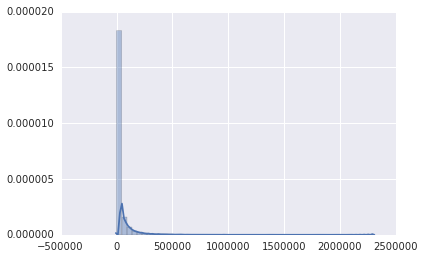

In [617]:
sns.distplot([len(interval) for interval in foo])

In [678]:
",".join("""TAG9_CLIP_S64_L005
TAG10_CLIP_S68
TAG13_CLIP
TAG11_CLIP_S69
TAG12_CLIP_S70
TAG14_CLIP_S73
TAG15_CLIP_S75
TAG16_CLIP_S77
TAG9_INPUT_S63
TAG10_INPUT_S65
TAG11_INPUT_S66
TAG12_INPUT_S67
TAG13_INPUT_S71
TAG14_INPUT_S72
TAG15_INPUT_S74
TAG16_INPUT_S76
TAG11_CLIP_S26
TAG14_CLIP_S30
SEB9_S92_L007
SEB5_S88_L007
SEB6_S89_L007
SEB7_S90_L007
SEB8_S91_L007
SEB17_S96_L007
SEB20_S99_L007
SEB10_S93_L007
SEB11_S94_L007
SEB12_S95_L007
SEB18_S97_L007
SEB19_S98_L007
SEB21_S100_L007
SEB23_S102_L007
SEB24_S103_L007
SEB22_S101_L007
SEB_unknown706504_S51
SEB_unknown706504
643_CLIP_S78_L005
363_INPUT_4000_S17_L001
386_INPUT_4000_S18""".split("\n"))

'TAG9_CLIP_S64_L005,TAG10_CLIP_S68,TAG13_CLIP,TAG11_CLIP_S69,TAG12_CLIP_S70,TAG14_CLIP_S73,TAG15_CLIP_S75,TAG16_CLIP_S77,TAG9_INPUT_S63,TAG10_INPUT_S65,TAG11_INPUT_S66,TAG12_INPUT_S67,TAG13_INPUT_S71,TAG14_INPUT_S72,TAG15_INPUT_S74,TAG16_INPUT_S76,TAG11_CLIP_S26,TAG14_CLIP_S30,SEB9_S92_L007,SEB5_S88_L007,SEB6_S89_L007,SEB7_S90_L007,SEB8_S91_L007,SEB17_S96_L007,SEB20_S99_L007,SEB10_S93_L007,SEB11_S94_L007,SEB12_S95_L007,SEB18_S97_L007,SEB19_S98_L007,SEB21_S100_L007,SEB23_S102_L007,SEB24_S103_L007,SEB22_S101_L007,SEB_unknown706504_S51,SEB_unknown706504,643_CLIP_S78_L005,363_INPUT_4000_S17_L001,386_INPUT_4000_S18'